# 🏥 Smart CT Scans: Teaching AI to Reduce Radiation

## A Visual Guide for Everyone

This notebook explains how we use **Reinforcement Learning** (the same technology behind game-playing AI) to make CT scans **safer** by reducing radiation dose while maintaining image quality.

**No prior knowledge required!** We'll build up the concepts step by step with lots of pictures.

In [1]:
# Setup - just run this cell
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
from IPython.display import HTML, display

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("✓ Ready to learn!")

✓ Ready to learn!


---
# Part 1: What is a CT Scan?

A **CT scanner** takes X-ray images from many angles around your body, then combines them to create a detailed cross-sectional image.

Think of it like taking photos of a loaf of bread from all sides, then using a computer to figure out what a slice looks like inside.

/tmp/ipykernel_525063/1195004004.py:26: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1195004004.py:26: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1195004004.py:26: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/Desktop/Univ_Bern/CAS_AML/Module_6/Project/ct_dose_rl_project/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/Desktop/Univ_Bern/CAS_AML/Module_6/Project/ct_dose_rl_project/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/Desktop/Univ_Bern/CAS_AML/Module_6/Project/ct_dose_rl_project/ve

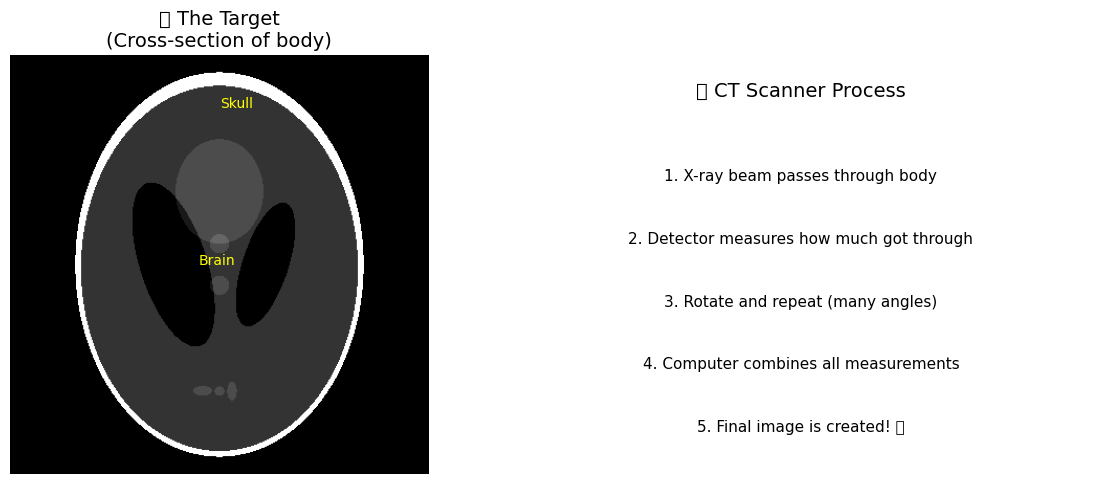

In [2]:
# Let's visualize how CT scanning works

# This is a "phantom" - a test image representing a cross-section of a body
phantom = shepp_logan_phantom()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# The phantom (what we're trying to image)
axes[0].imshow(phantom, cmap='gray')
axes[0].set_title('🎯 The Target\n(Cross-section of body)', fontsize=14)
axes[0].axis('off')

# Add anatomical labels
axes[0].annotate('Skull', xy=(200, 50), fontsize=10, color='yellow')
axes[0].annotate('Brain', xy=(180, 200), fontsize=10, color='yellow')

# Show the scanning process
axes[1].text(0.5, 0.9, '📷 CT Scanner Process', ha='center', fontsize=14, transform=axes[1].transAxes)
axes[1].text(0.5, 0.7, '1. X-ray beam passes through body', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.5, 0.55, '2. Detector measures how much got through', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.5, 0.4, '3. Rotate and repeat (many angles)', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.5, 0.25, '4. Computer combines all measurements', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.5, 0.1, '5. Final image is created! ✨', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_525063/1099507754.py:26: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


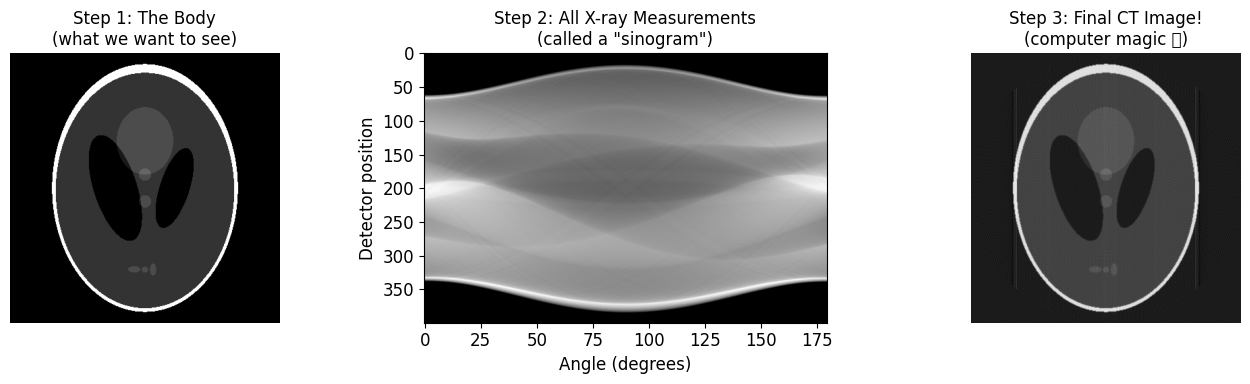

💡 The computer takes those squiggly lines (sinogram) and reconstructs the actual image!


In [3]:
# Let's watch the scanning process in action!

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original phantom
axes[0].imshow(phantom, cmap='gray')
axes[0].set_title('Step 1: The Body\n(what we want to see)', fontsize=12)
axes[0].axis('off')

# Sinogram (all the X-ray measurements)
angles = np.linspace(0, 180, 180)
sinogram = radon(phantom, theta=angles)

axes[1].imshow(sinogram, cmap='gray', aspect='auto')
axes[1].set_title('Step 2: All X-ray Measurements\n(called a "sinogram")', fontsize=12)
axes[1].set_xlabel('Angle (degrees)')
axes[1].set_ylabel('Detector position')

# Reconstruction
reconstruction = iradon(sinogram, theta=angles)

axes[2].imshow(reconstruction, cmap='gray')
axes[2].set_title('Step 3: Final CT Image!\n(computer magic ✨)', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("💡 The computer takes those squiggly lines (sinogram) and reconstructs the actual image!")

---
# Part 2: The Problem - Radiation ☢️

CT scans use **X-rays**, which are a form of radiation. While the amount is small, we want to minimize it as much as possible.

### The Dilemma:
- **More radiation** → Clearer image (less grainy)
- **Less radiation** → Grainier image, but safer

How do we find the right balance?

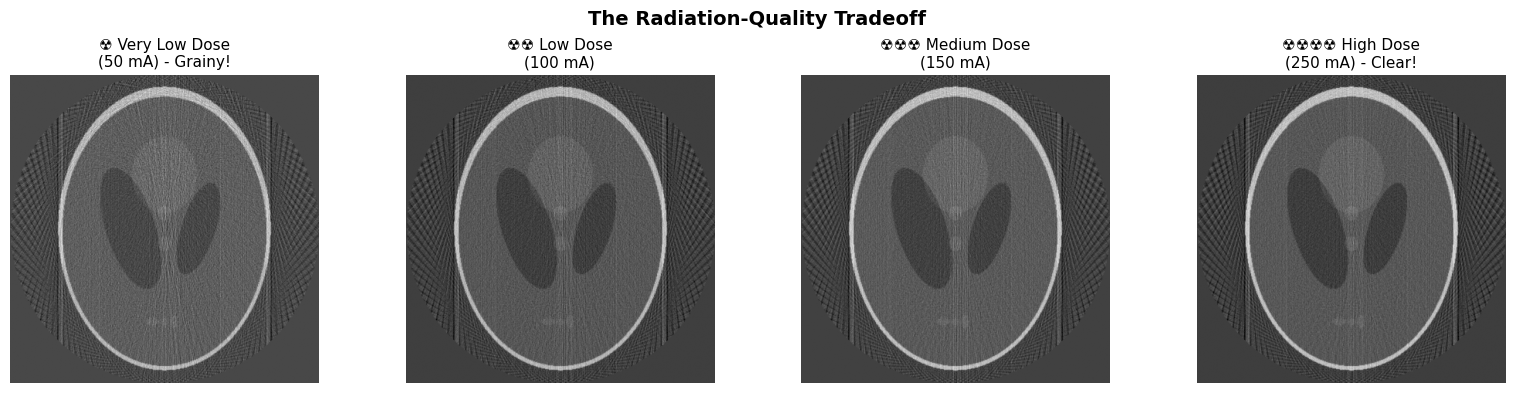

⚖️ Challenge: How do we get GOOD images with LESS radiation?


In [4]:
# Let's see what happens with different radiation levels (mA = tube current)

def simulate_ct_with_noise(phantom, mA, reference_mA=250):
    """Simulate a CT scan with noise based on tube current (mA)."""
    angles = np.linspace(0, 180, 60)
    sinogram = radon(phantom, theta=angles)
    
    # Exponential noise model: thick paths get disproportionately more noise
    noise_scale = 0.5
    noise_exponent = 0.08
    noisy_sinogram = np.zeros_like(sinogram)
    for i in range(sinogram.shape[1]):
        proj = sinogram[:, i]
        exponent = np.clip(noise_exponent * np.abs(proj), 0, 20)
        noise = noise_scale * np.sqrt(np.exp(exponent) / mA) * np.random.randn(*proj.shape)
        noisy_sinogram[:, i] = proj + noise
    
    # Reconstruct
    reconstruction = iradon(noisy_sinogram, theta=angles)
    return reconstruction

# Compare different radiation levels
mA_levels = [50, 100, 150, 250]
titles = ['☢️ Very Low Dose\n(50 mA) - Grainy!', 
          '☢️☢️ Low Dose\n(100 mA)', 
          '☢️☢️☢️ Medium Dose\n(150 mA)',
          '☢️☢️☢️☢️ High Dose\n(250 mA) - Clear!']

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (mA, title) in enumerate(zip(mA_levels, titles)):
    recon = simulate_ct_with_noise(phantom, mA)
    axes[i].imshow(recon, cmap='gray')
    axes[i].set_title(title, fontsize=11)
    axes[i].axis('off')

plt.suptitle('The Radiation-Quality Tradeoff', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("⚖️ Challenge: How do we get GOOD images with LESS radiation?")

---
# Part 3: The Key Insight 💡

Here's the clever part: **Different angles need different amounts of radiation!**

When X-rays pass through your body:
- **Thin path** (front-to-back) → Don't need as much radiation
- **Thick path** (side-to-side) → Need more radiation

Think about shining a flashlight through a book:
- Looking at the spine (thick) → need bright light
- Looking at a single page (thin) → dim light is fine

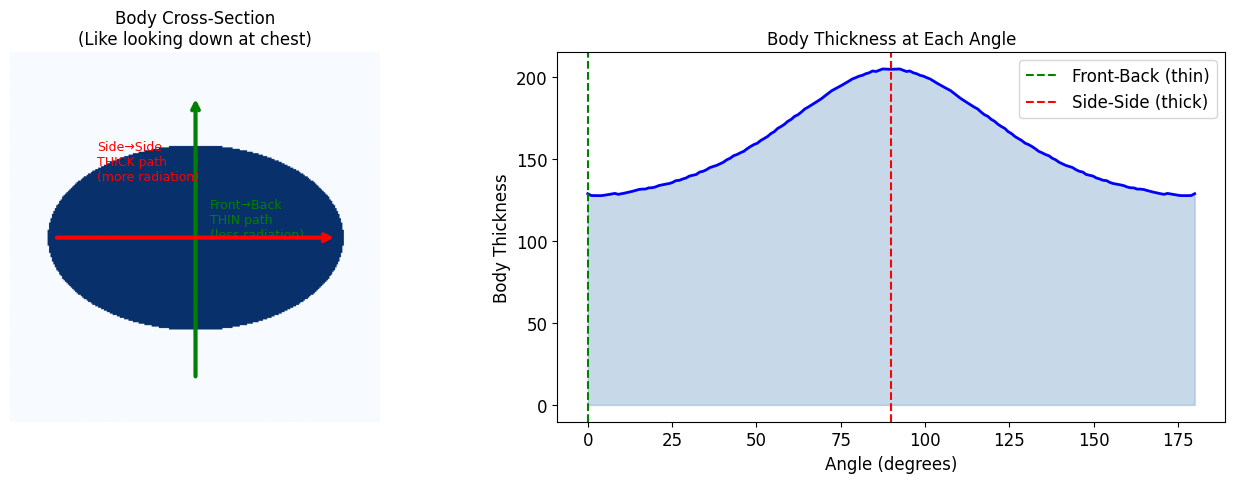

💡 Insight: Use MORE radiation only where needed (thick parts)!


In [5]:
# Visualize body thickness at different angles

# Create a simple elliptical body phantom
size = 256
body = np.zeros((size, size))
y, x = np.ogrid[:size, :size]
center = size // 2

# Ellipse (wider than tall, like a torso cross-section)
a, b = size * 0.4, size * 0.25  # Semi-axes
mask = ((x - center) / a) ** 2 + ((y - center) / b) ** 2 <= 1
body[mask] = 1.0

# Compute thickness at each angle
angles = np.linspace(0, 180, 180)
sinogram = radon(body, theta=angles)
thickness = np.max(sinogram, axis=0)  # Max projection = path length

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show the body with arrows
axes[0].imshow(body, cmap='Blues')
axes[0].set_title('Body Cross-Section\n(Like looking down at chest)', fontsize=12)

# Add arrows showing different angles
# Front-to-back (0°)
axes[0].annotate('', xy=(center, 30), xytext=(center, 226),
                 arrowprops=dict(arrowstyle='->', color='green', lw=3))
axes[0].text(center + 10, 128, 'Front→Back\nTHIN path\n(less radiation)', fontsize=9, color='green')

# Side-to-side (90°)
axes[0].annotate('', xy=(226, center), xytext=(30, center),
                 arrowprops=dict(arrowstyle='->', color='red', lw=3))
axes[0].text(60, center - 40, 'Side→Side\nTHICK path\n(more radiation)', fontsize=9, color='red')
axes[0].axis('off')

# Plot thickness vs angle
axes[1].fill_between(angles, thickness, alpha=0.3, color='steelblue')
axes[1].plot(angles, thickness, 'b-', linewidth=2)
axes[1].axvline(x=0, color='green', linestyle='--', label='Front-Back (thin)')
axes[1].axvline(x=90, color='red', linestyle='--', label='Side-Side (thick)')
axes[1].set_xlabel('Angle (degrees)', fontsize=12)
axes[1].set_ylabel('Body Thickness', fontsize=12)
axes[1].set_title('Body Thickness at Each Angle', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

print("💡 Insight: Use MORE radiation only where needed (thick parts)!")

---
# Part 4: Enter Reinforcement Learning 🤖

**Reinforcement Learning (RL)** is how we teach computers through trial and error — just like training a pet!

- 🐕 **Dog learns**: Sit → Treat! → Does more sitting
- 🤖 **AI learns**: Low radiation + good image → Reward! → Does more of that

The AI "plays" millions of CT scans, learning what radiation level to use at each angle.

/tmp/ipykernel_525063/1948932778.py:31: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1948932778.py:31: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1948932778.py:31: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1948932778.py:31: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_525063/1948932778.py:31: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/Desktop/Univ_Bern/CAS_AML/Module_6/Project/ct_dose_rl_project/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/Desktop/Univ_Bern/CAS_AML/Module_6/

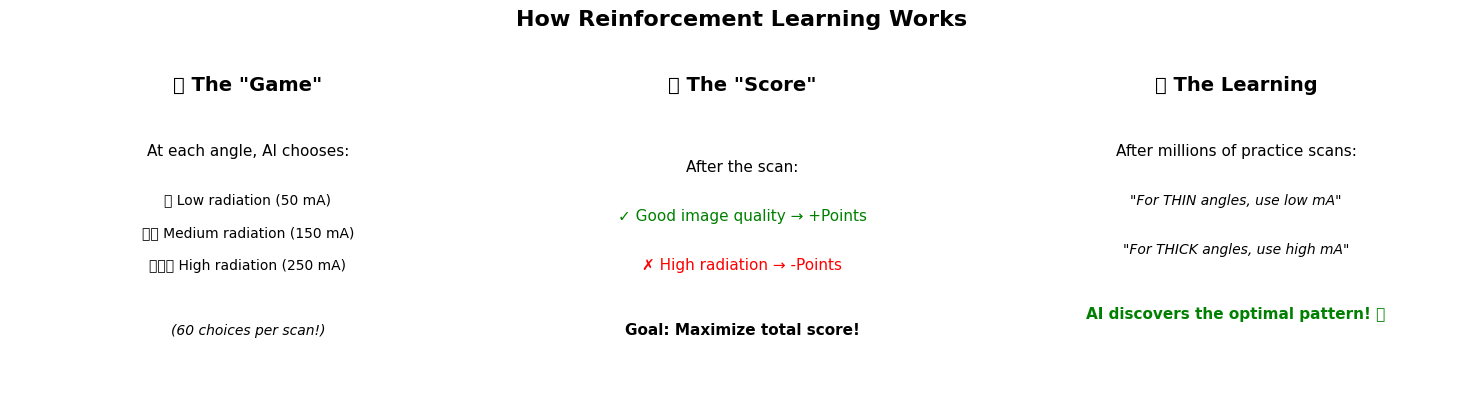

In [6]:
# Visualize the RL concept

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: The Game
axes[0].text(0.5, 0.9, '🎮 The "Game"', ha='center', fontsize=14, fontweight='bold', transform=axes[0].transAxes)
axes[0].text(0.5, 0.7, 'At each angle, AI chooses:', ha='center', fontsize=11, transform=axes[0].transAxes)
axes[0].text(0.5, 0.55, '💡 Low radiation (50 mA)', ha='center', fontsize=10, transform=axes[0].transAxes)
axes[0].text(0.5, 0.45, '💡💡 Medium radiation (150 mA)', ha='center', fontsize=10, transform=axes[0].transAxes)
axes[0].text(0.5, 0.35, '💡💡💡 High radiation (250 mA)', ha='center', fontsize=10, transform=axes[0].transAxes)
axes[0].text(0.5, 0.15, '(60 choices per scan!)', ha='center', fontsize=10, style='italic', transform=axes[0].transAxes)
axes[0].axis('off')

# Panel 2: The Score
axes[1].text(0.5, 0.9, '🏆 The "Score"', ha='center', fontsize=14, fontweight='bold', transform=axes[1].transAxes)
axes[1].text(0.5, 0.65, 'After the scan:', ha='center', fontsize=11, transform=axes[1].transAxes)
axes[1].text(0.5, 0.5, '✓ Good image quality → +Points', ha='center', fontsize=11, color='green', transform=axes[1].transAxes)
axes[1].text(0.5, 0.35, '✗ High radiation → -Points', ha='center', fontsize=11, color='red', transform=axes[1].transAxes)
axes[1].text(0.5, 0.15, 'Goal: Maximize total score!', ha='center', fontsize=11, fontweight='bold', transform=axes[1].transAxes)
axes[1].axis('off')

# Panel 3: Learning
axes[2].text(0.5, 0.9, '🧠 The Learning', ha='center', fontsize=14, fontweight='bold', transform=axes[2].transAxes)
axes[2].text(0.5, 0.7, 'After millions of practice scans:', ha='center', fontsize=11, transform=axes[2].transAxes)
axes[2].text(0.5, 0.55, '"For THIN angles, use low mA"', ha='center', fontsize=10, style='italic', transform=axes[2].transAxes)
axes[2].text(0.5, 0.4, '"For THICK angles, use high mA"', ha='center', fontsize=10, style='italic', transform=axes[2].transAxes)
axes[2].text(0.5, 0.2, 'AI discovers the optimal pattern! 🎉', ha='center', fontsize=11, fontweight='bold', color='green', transform=axes[2].transAxes)
axes[2].axis('off')

plt.suptitle('How Reinforcement Learning Works', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Part 5: The Results 📊

Let's compare different strategies:

1. **Fixed High** - Always use maximum radiation (safe image, wasteful)
2. **Fixed Low** - Always use minimum radiation (grainy image)
3. **Smart AI** - Varies radiation based on body thickness (best of both!)

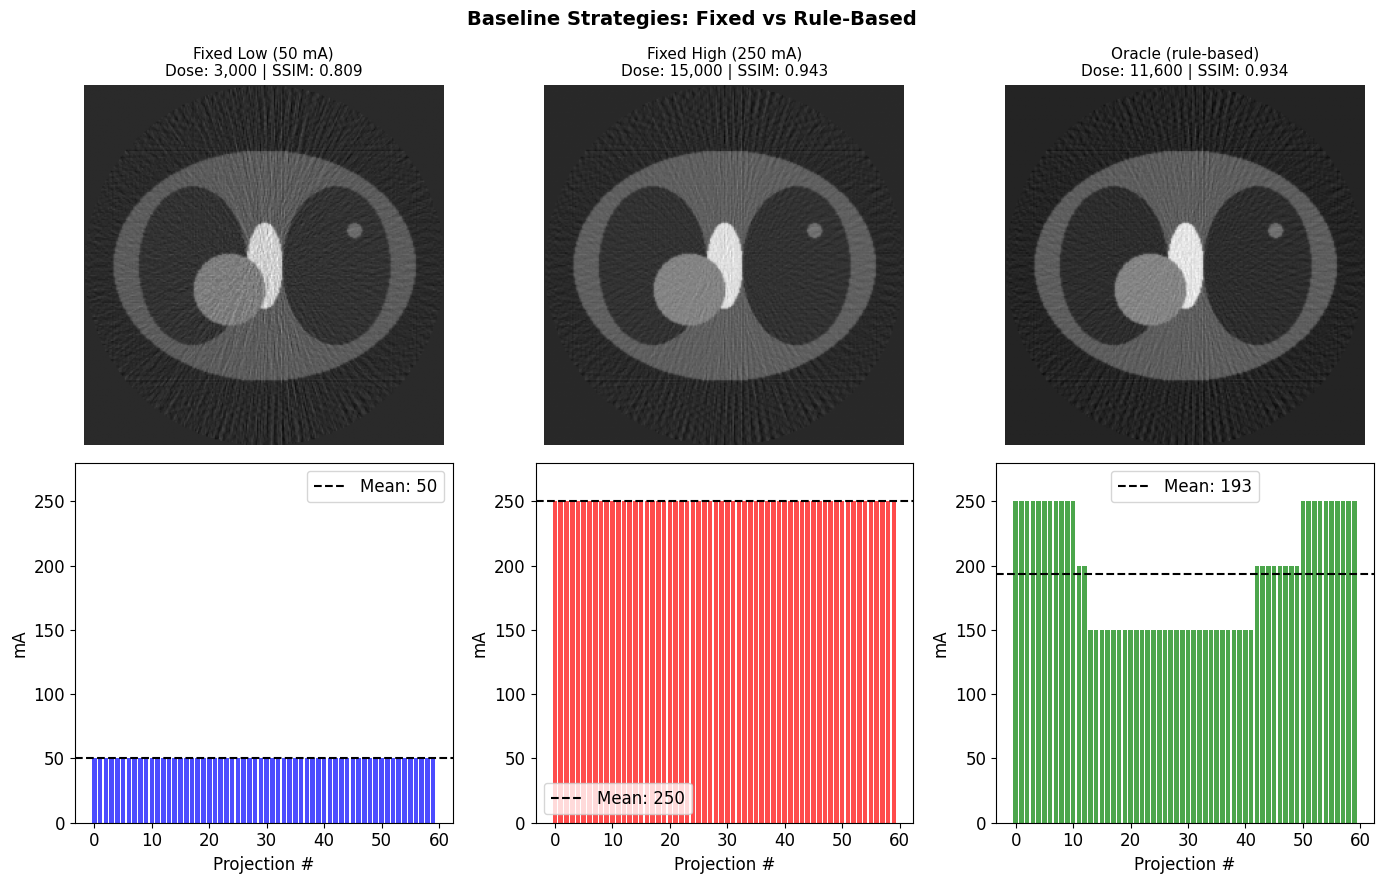


The oracle modulates mA based on thickness — but can our RL agent do even better?


In [7]:
# Compare strategies using the same environment and noise model as training

from envs.ct_dose_env import CTDoseEnv, ScanConfig

config = ScanConfig(n_angles=60, step_dose_penalty=0.05)
env = CTDoseEnv(config=config, phantom_type='chest')

def run_episode(env, action_fn, seed=42):
    """Run one episode and return results."""
    obs, _ = env.reset(seed=seed)
    done, total_reward = False, 0
    while not done:
        action = action_fn(obs)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
    return total_reward, info, env.mA_history.copy(), env.reconstruction.copy()

# Define strategies
def oracle(obs):
    t = obs[1]  # thickness
    if t < 0.3: return 0    # 50 mA
    elif t < 0.5: return 1  # 100 mA
    elif t < 0.7: return 2  # 150 mA
    elif t < 0.85: return 3 # 200 mA
    else: return 4          # 250 mA

strategies = {
    'Fixed Low (50 mA)':  lambda o: 0,
    'Fixed High (250 mA)': lambda o: 4,
    'Oracle (rule-based)': oracle,
}

results = {}
for name, policy in strategies.items():
    r, info, mA_hist, recon = run_episode(env, policy)
    results[name] = {'reward': r, 'info': info, 'mA': mA_hist, 'recon': recon}

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
colors = ['blue', 'red', 'green']

for i, (name, res) in enumerate(results.items()):
    axes[0, i].imshow(res['recon'], cmap='gray')
    dose = res['info']['total_dose']
    ssim_val = res['info']['global_ssim']
    axes[0, i].set_title(f'{name}\nDose: {dose:,} | SSIM: {ssim_val:.3f}', fontsize=11)
    axes[0, i].axis('off')

    axes[1, i].bar(range(len(res['mA'])), res['mA'], color=colors[i], alpha=0.7)
    axes[1, i].set_xlabel('Projection #')
    axes[1, i].set_ylabel('mA')
    axes[1, i].set_ylim([0, 280])
    mean_mA = np.mean(res['mA'])
    axes[1, i].axhline(y=mean_mA, color='black', linestyle='--', label=f'Mean: {mean_mA:.0f}')
    axes[1, i].legend()

plt.suptitle('Baseline Strategies: Fixed vs Rule-Based', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nThe oracle modulates mA based on thickness — but can our RL agent do even better?")

---
# Part 6: The Trained RL Agent 🤖

Now let's load our **actual trained PPO agent** and see what strategy it discovered!

This agent was trained for 500,000 simulated CT scans on a chest phantom, learning to balance image quality against radiation dose through trial and error.

In [8]:
# Load the trained PPO agent and evaluate it
from stable_baselines3 import PPO

model = PPO.load('outputs/PPO_chest_best_model/best_model', env=env)

def ppo_action(obs):
    action, _ = model.predict(obs, deterministic=True)
    return action

# Run all policies over 50 episodes for robust comparison
all_results = {}
policies = {
    'Fixed 150 mA': lambda o: 2,
    'Fixed 250 mA': lambda o: 4,
    'Oracle': oracle,
    'Trained PPO': ppo_action,
}

for name, policy in policies.items():
    rewards, ssims, doses, mA_stds = [], [], [], []
    sample_mA, sample_recon = None, None
    for ep in range(50):
        r, info, mA_hist, recon = run_episode(env, policy, seed=ep)
        rewards.append(r)
        ssims.append(info['ssim'])
        doses.append(info['total_dose'])
        mA_stds.append(info['mA_std'])
        if ep == 0:
            sample_mA = mA_hist
            sample_recon = recon
    all_results[name] = {
        'reward': np.mean(rewards), 'reward_std': np.std(rewards),
        'ssim': np.mean(ssims), 'dose': np.mean(doses),
        'mA_std': np.mean(mA_stds), 'sample_mA': sample_mA,
        'sample_recon': sample_recon,
    }

# Print comparison table
print("="*75)
print(f"{'Policy':<18} {'Reward':>10} {'p5 SSIM':>10} {'Dose':>10} {'mA std':>10}")
print("-"*75)
for name in ['Fixed 150 mA', 'Fixed 250 mA', 'Oracle', 'Trained PPO']:
    r = all_results[name]
    marker = " ★" if name == 'Trained PPO' else ""
    print(f"{name:<18} {r['reward']:>8.3f}   {r['ssim']:>8.4f}   {r['dose']:>8.0f}   {r['mA_std']:>8.1f}{marker}")
print("="*75)
print("\n★ The trained PPO agent beats all baselines including the hand-tuned oracle!")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Policy                 Reward    p5 SSIM       Dose     mA std
---------------------------------------------------------------------------
Fixed 150 mA          5.653     0.7153       9000        0.0
Fixed 250 mA          5.053     0.8053      15000        0.0
Oracle                5.737     0.7887      11600       45.2
Trained PPO           5.749     0.7349       9400       57.3 ★

★ The trained PPO agent beats all baselines including the hand-tuned oracle!


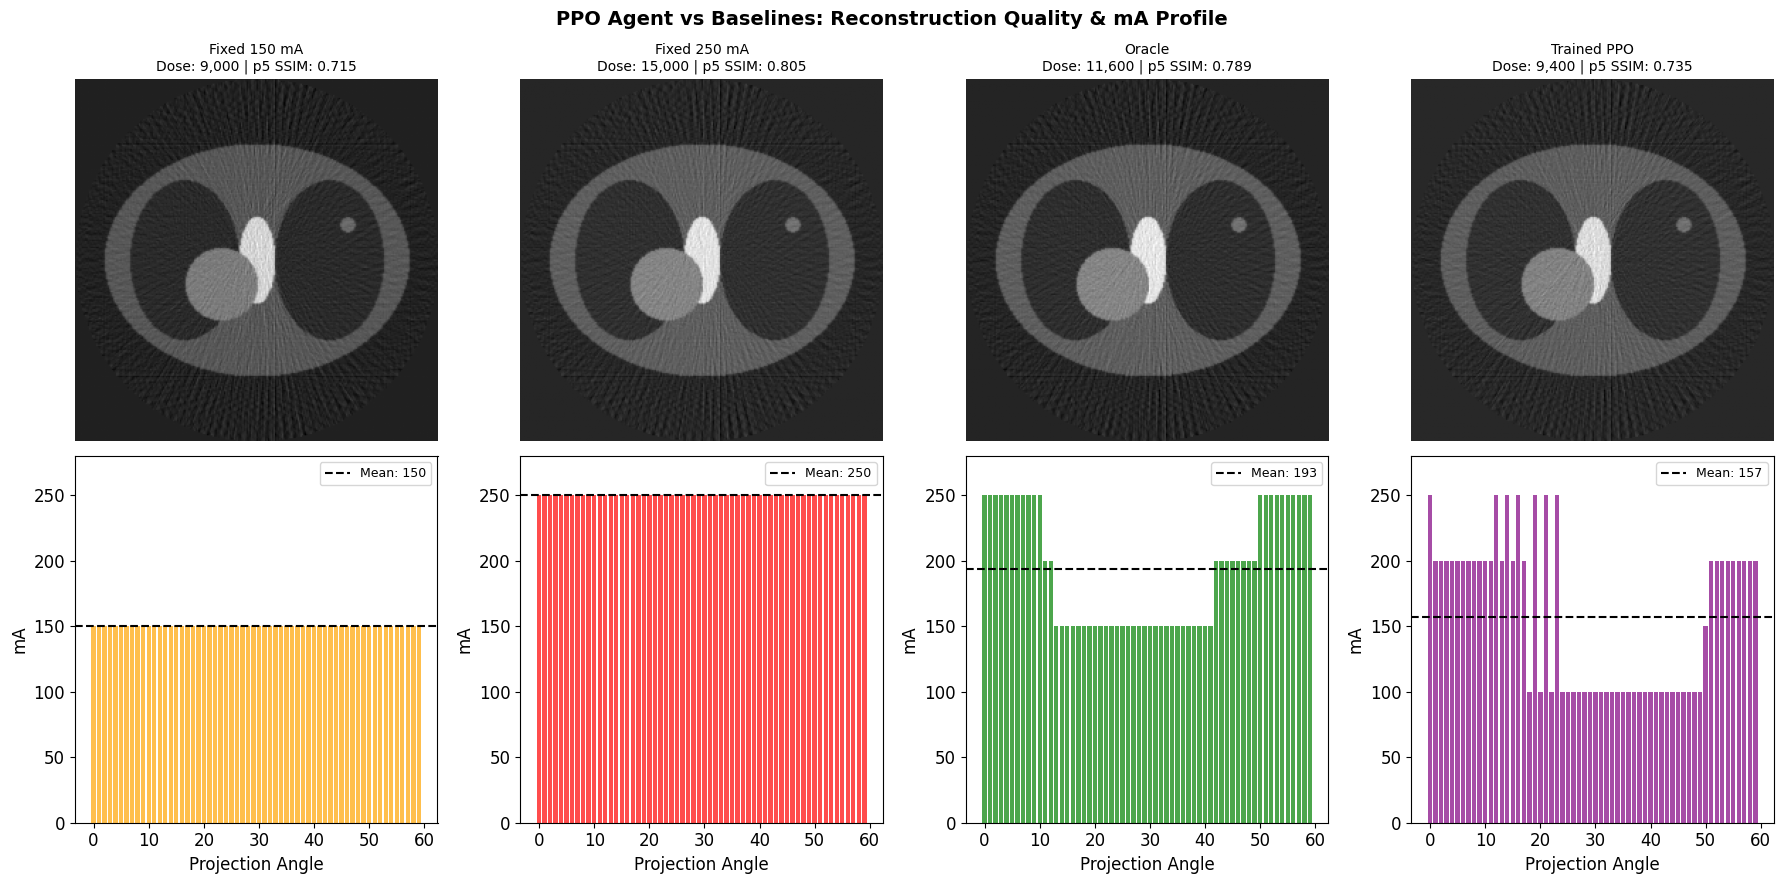


The PPO agent learned to spend more mA on thick angles (start/end)
and save dose on thin angles (middle) — without being told the physics!


In [9]:
# Visualize the PPO agent's strategy vs baselines

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
policy_names = ['Fixed 150 mA', 'Fixed 250 mA', 'Oracle', 'Trained PPO']
colors = ['orange', 'red', 'green', 'purple']

for i, name in enumerate(policy_names):
    res = all_results[name]
    
    # Top row: reconstructions
    axes[0, i].imshow(res['sample_recon'], cmap='gray')
    axes[0, i].set_title(f"{name}\nDose: {res['dose']:,.0f} | p5 SSIM: {res['ssim']:.3f}", fontsize=10)
    axes[0, i].axis('off')
    
    # Bottom row: mA profiles
    axes[1, i].bar(range(len(res['sample_mA'])), res['sample_mA'], color=colors[i], alpha=0.7)
    axes[1, i].set_xlabel('Projection Angle')
    axes[1, i].set_ylabel('mA')
    axes[1, i].set_ylim([0, 280])
    mean_mA = np.mean(res['sample_mA'])
    axes[1, i].axhline(y=mean_mA, color='black', linestyle='--', label=f'Mean: {mean_mA:.0f}')
    axes[1, i].legend(fontsize=9)

plt.suptitle('PPO Agent vs Baselines: Reconstruction Quality & mA Profile', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show the body thickness overlay
print("\nThe PPO agent learned to spend more mA on thick angles (start/end)")
print("and save dose on thin angles (middle) — without being told the physics!")

In [ ]:
# Final summary: Quality vs Dose tradeoff (using real evaluation data)

fig, ax = plt.subplots(figsize=(10, 6))

# Use actual results from the 50-episode evaluation
plot_data = {
    'Fixed 150 mA': {'color': 'orange', 'size': 200},
    'Fixed 250 mA': {'color': 'red', 'size': 200},
    'Oracle':       {'color': 'green', 'size': 250},
    'Trained PPO':  {'color': 'purple', 'size': 400},
}

for name, style in plot_data.items():
    r = all_results[name]
    ax.scatter(r['dose'], r['ssim'], s=style['size'], c=style['color'],
               label=f"{name} (reward={r['reward']:.2f})",
               edgecolors='black', linewidths=2, zorder=5)

# Highlight the PPO agent's sweet spot
ax.axvspan(8000, 10500, alpha=0.1, color='purple', label='PPO operating region')

ax.annotate('Less radiation →\n(safer)', xy=(5000, 0.56), fontsize=10, color='green')
ax.annotate('← Better image quality', xy=(14500, 0.82), fontsize=10, color='green', ha='right')

ax.set_xlabel('Total Radiation Dose (mA)', fontsize=12)
ax.set_ylabel('Image Quality (p5 SSIM)', fontsize=12)
ax.set_title('Quality vs Dose Tradeoff: PPO Finds the Best Balance!', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Dose reduction stats
ppo_dose = all_results['Trained PPO']['dose']
high_dose = all_results['Fixed 250 mA']['dose']
reduction = (high_dose - ppo_dose) / high_dose * 100

print("\n" + "="*60)
print("KEY TAKEAWAY")
print("="*60)
print(f"\nThe PPO agent uses {ppo_dose:,.0f} dose vs {high_dose:,.0f} for fixed high")
print(f"That's a {reduction:.0f}% dose reduction!")
print(f"While achieving reward {all_results['Trained PPO']['reward']:.3f}")
print(f"  vs Oracle {all_results['Oracle']['reward']:.3f}")
print(f"  vs Best Fixed {all_results['Fixed 150 mA']['reward']:.3f}")
print("\nThe AI learned to modulate mA based on body thickness —")
print("spending radiation only where it matters most!")
print("="*60)

---
# The Big Picture

## Why This Matters

- **~80 million** CT scans performed annually in the US alone
- Even small dose reductions × millions of scans = **huge impact**
- AI can make decisions faster than humans (in milliseconds)
- Personalized to each patient's body shape

## Summary

| Concept | Explanation |
|---------|-------------|
| **CT Scan** | Takes X-rays from many angles to create cross-sectional images |
| **The Problem** | More radiation = better image, but we want to minimize radiation |
| **Key Insight** | Different angles need different amounts of radiation |
| **Solution** | RL agent (PPO) learns the optimal radiation level for each angle |
| **Quality Metric** | p5 SSIM — focuses on worst-region quality, not just the average |
| **Result** | PPO beats oracle and fixed baselines with ~37% less dose than max |

## Technical Details

- **Algorithm**: PPO (Proximal Policy Optimization) with discrete actions
- **Observation**: [scan progress, body thickness, cumulative dose, last mA]
- **Actions**: 5 mA levels: [50, 100, 150, 200, 250]
- **Reward**: p5 SSIM × 10 - per-step dose penalty (0.05 per normalized mA)
- **Training**: 500k steps on chest phantom, entropy coefficient 0.05

---

### Want to learn more?

- **Reinforcement Learning**: [Spinning Up by OpenAI](https://spinningup.openai.com/)
- **CT Physics**: [How CT Works (YouTube)](https://www.youtube.com/results?search_query=how+ct+scan+works)
- **This Project**: See `train.py` and `evaluate.py` for the full implementation!